In [7]:
import pandas as pd
import numpy as np
import time
import os
from ast import literal_eval
from typing import List

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme(color_codes=True)

In [8]:
df_orig = pd.read_csv('games_with_cp_metrics.csv')
print(df_orig.shape)
df_orig.head()

(24293, 9)


,event,date,player,elo,color,opponent,result,avg_cp_loss,std_cp_loss
0,US Amateur Team East,2002.02.16,"Caruana,F",2032.0,black,"Milovanovic,Dragan",draw,34.440000,43.936390
1,New York State-ch,2002.08.31,"Caruana,F",2040.0,black,"Simon,Jerry C",draw,46.000000,88.329739
2,New York State-ch,2002.09.01,"Dolgitser,K",2262.0,white,"Caruana,F",won,47.589744,100.842786
3,New York State-ch,2002.09.01,"Caruana,F",2040.0,black,"Dolgitser,K",lost,68.131579,134.498908
4,New York State-ch,2002.09.01,"Caruana,F",2040.0,white,"Agaian,Sarkis",won,38.916667,49.042145


In [10]:
def create_tiers(start: int, end: int, size: int = 25) -> dict:
    tier_ranges = {}
    while start < end:
        tier_ranges[range(start, start+size)] = start
        start += size
    return tier_ranges

def get_tier(value: int, tiers: dict) -> int:
    for k, v in tiers.items():
        if value in k:
            return v
    return None

def add_tiers_to_df(df_: pd.DataFrame, start_elo: int, end_elo: int, tier_size=50) -> pd.DataFrame:
    df = df_.copy()
    tier_ranges = create_tiers(start=start_elo, end=end_elo, size=tier_size)
    df['tier'] = df['elo'].apply(lambda x: get_tier(x, tier_ranges))
    return df

def get_acpl_and_stdcpl_by_tier(df: pd.DataFrame) -> pd.DataFrame:
    grouped_agg = df.groupby(['tier'])[['avg_cp_loss', 'std_cp_loss']].mean().reset_index()
    return grouped_agg[['tier', 'avg_cp_loss', 'std_cp_loss']]


def plot_acpl_and_stdcpl_by_tier(df_: pd.DataFrame, player: str = 'all'):
    df = df_.copy()
    if player != 'all':
        df = df[df['player'].str.contains(player)].copy()
    
    player_acpl_and_stdcpl_by_tier = get_acpl_and_stdcpl_by_tier(df)
    if len(player_acpl_and_stdcpl_by_tier) == 0:
        print(f'Found no games for player: {player}.')

    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.regplot(x='tier', y='avg_cp_loss', data=player_acpl_and_stdcpl_by_tier, ax=axes[0])
    corr = player_acpl_and_stdcpl_by_tier[['tier', 'avg_cp_loss']].corr().iloc[0, 1]
    axes[0].set_title(f'Avg CP loss vs Rating | Corr: {corr:.3f}');

    sns.regplot(x='tier', y='std_cp_loss', data=player_acpl_and_stdcpl_by_tier, ax=axes[1])
    corr = player_acpl_and_stdcpl_by_tier[['tier', 'std_cp_loss']].corr().iloc[0, 1]
    axes[1].set_title(f'Std CP loss vs Rating | Corr: {corr:.3f}')
    plt.suptitle(player)
    plt.show();

In [11]:
relevant_players = [
    'Anand', 
    'Aronian', 
    'Carlsen', 
    'Caruana', 
    'Ding', 
    'Duda', 
    'So', 
    'Polgar', 
    'Nepo', 
    'Jobava', 
    'Firouzja', 
    'Sarin',
    'Niemann',
    'Pragg',
    'Gukesh',
    'Keymer',
]

#### Filter out unrelevant players 

In [12]:
df = df_orig.copy()
print(f'Num players: {len(df["player"].unique())}')

Num players: 3886


However, this also includes the opponents of the relevant players.  
Also, some of the relevant players are represented with somewhat different naming format for different games,    
and there are some players that share last name with some of the relevant players.  
A manual filtering is required to make sure we only keep games of the players we want. 

In [13]:
def print_num_games_of_players(df: pd.DataFrame, players: List[str]):
    for player in players:
        print(f'---------- {player} ----------')
        print(df[df['player'].apply(lambda x: x.lower()).str.contains(player.lower())]['player'].value_counts())

In [14]:
print_num_games_of_players(df, relevant_players)

---------- Anand ----------
Anand, Viswanathan    969
Praggnanandhaa R,     502
Anand,V                78
Pranav, Anand           5
Praggnanandhaa,R        3
Anand Nadar,            2
Saurabh,Anand           1
Poobesh Anand,S         1
Name: player, dtype: int64
---------- Aronian ----------
Aronian,L         849
Aronian, Levon    217
Name: player, dtype: int64
---------- Carlsen ----------
Carlsen,M          1017
Carlsen, Magnus      18
Carlsen,H             1
Name: player, dtype: int64
---------- Caruana ----------
Caruana,F           1117
Caruana, Fabiano       7
Name: player, dtype: int64
---------- Ding ----------
Ding Liren     922
Ding,L           2
Dinger,F         1
Ding, Liren      1
Name: player, dtype: int64
---------- Duda ----------
Duda,J                 723
Duda, Jan Krzysztof     15
Name: player, dtype: int64
---------- So ----------
So,W                        995
Maghsoodloo, Parham          14
Nguyen Ngoc Truong Son       14
Robson,R                     12
Sokolov,I

In [15]:
keep_names = set([
    'Anand, Viswanathan',
    'Aronian,L',
    'Aronian, Levon',
    'Carlsen,M',
    'Caruana,F',
    'Ding Liren',
    'Duda,J',
    'So,W',
    'Polgar, Judit',
    'Nepomniachtchi,I',
    'Jobava,Ba',
    'Firouzja,Alireza',
    'Nihal Sarin,',         # Yep, there is an extra comma some places
    'Niemann, Hans Moke',
    'Praggnanandhaa R,',
    'Gukesh D,',             
    'Keymer, Vincent',
])

In [16]:
df = df[df['player'].apply(lambda x: x.strip()).isin(keep_names)]
df['player'] = df['player'].apply(lambda x: x.split(',')[0])
df.loc[df['player'] == 'Praggnanandhaa R', 'player'] = 'Praggnanandhaa'
df.loc[df['player'] == 'Gukesh D', 'player'] = 'Gukesh'
df.loc[df['player'] == 'Nihal Sarin', 'player'] = 'Sarin'
df.loc[df['player'] == 'Ding Liren', 'player'] = 'Ding'

In [17]:
df['player'].value_counts()

Caruana           1117
Aronian           1066
Carlsen           1017
So                 995
Anand              969
Jobava             964
Ding               922
Polgar             805
Firouzja           765
Nepomniachtchi     739
Duda               723
Gukesh             509
Sarin              507
Praggnanandhaa     502
Niemann            497
Keymer             392
Name: player, dtype: int64

In [18]:
start_elo, end_elo = 2000, 2900
tier_size = 50
df = add_tiers_to_df(df, start_elo, end_elo, tier_size)

#### Num games per tier

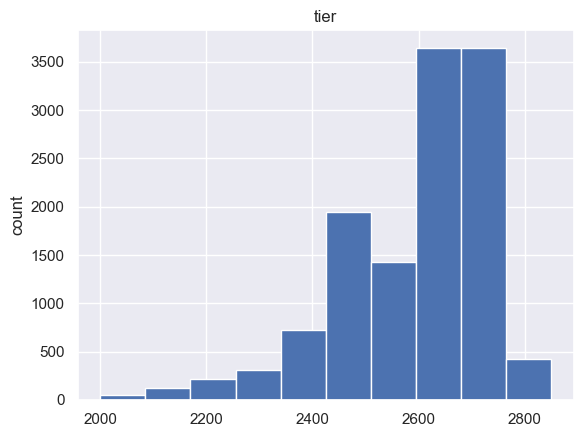

In [19]:
df.hist('tier')
plt.ylabel('count')
plt.show();

#### Num games per tier per player

/var/folders/r7/3_z3p06n3m79fcylhf7268r00000gn/T/ipykernel_68826/723142817.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist('tier', by='player', ax=ax);


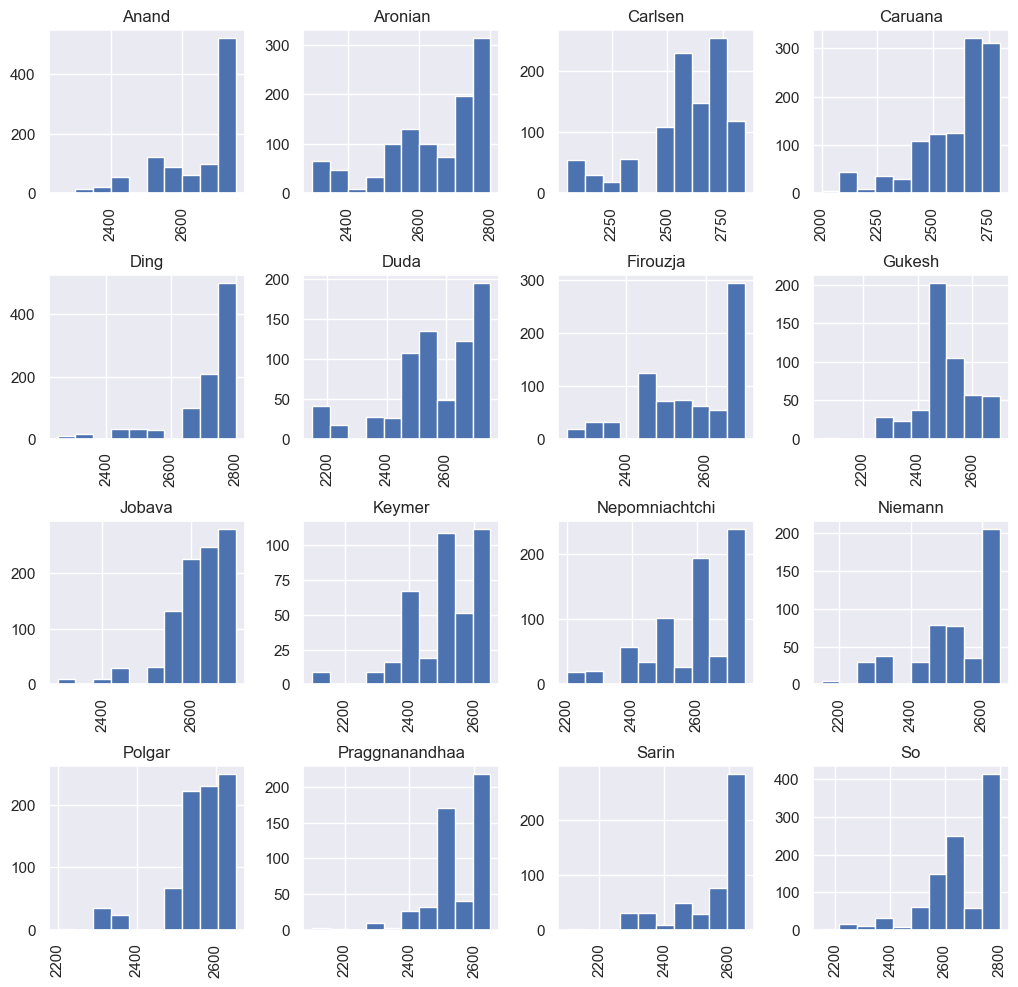

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
df.hist('tier', by='player', ax=ax);

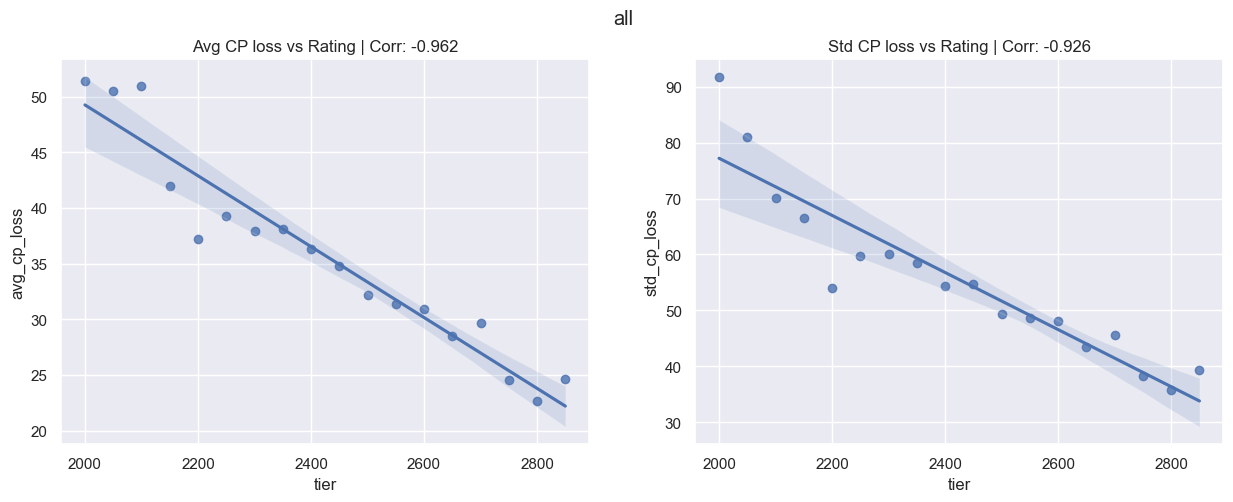

In [15]:
plot_acpl_and_stdcpl_by_tier(df, 'all')

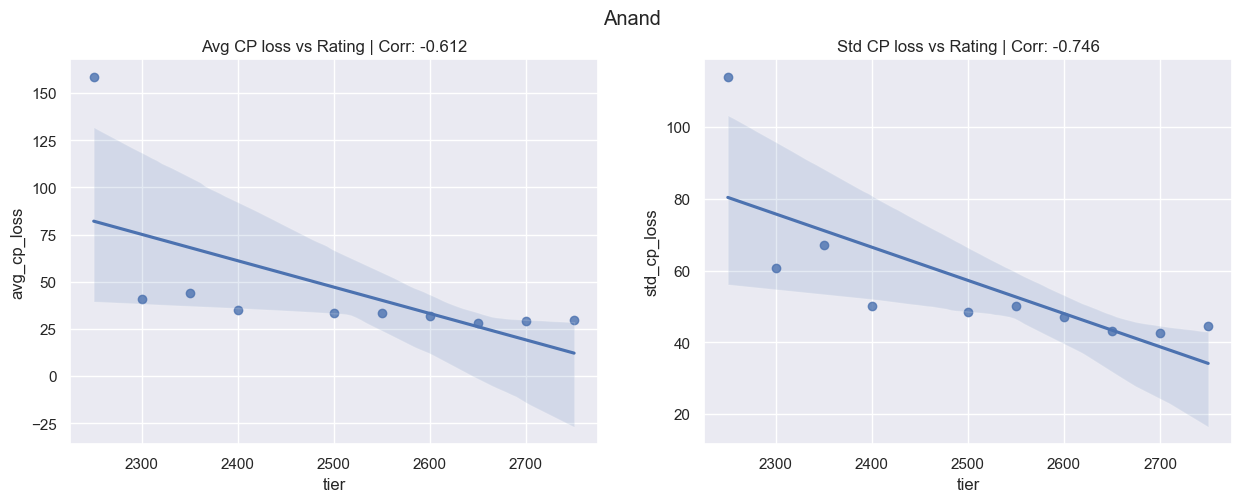

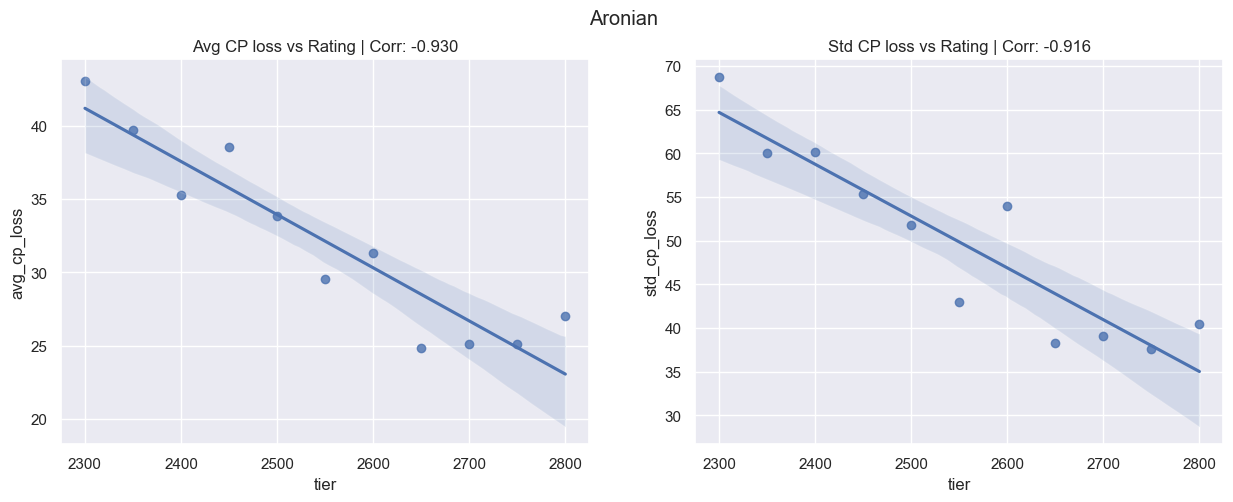

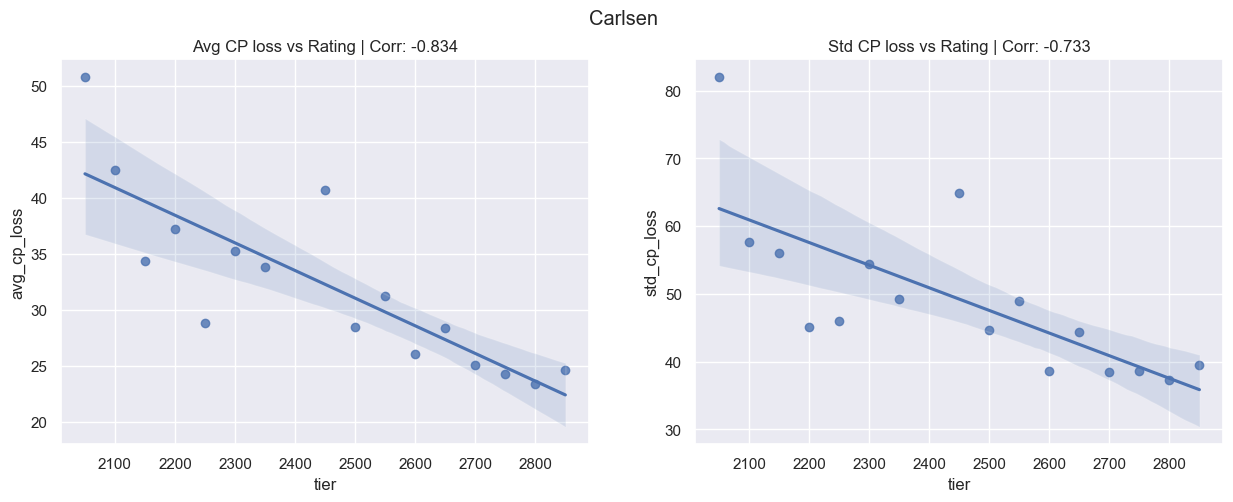

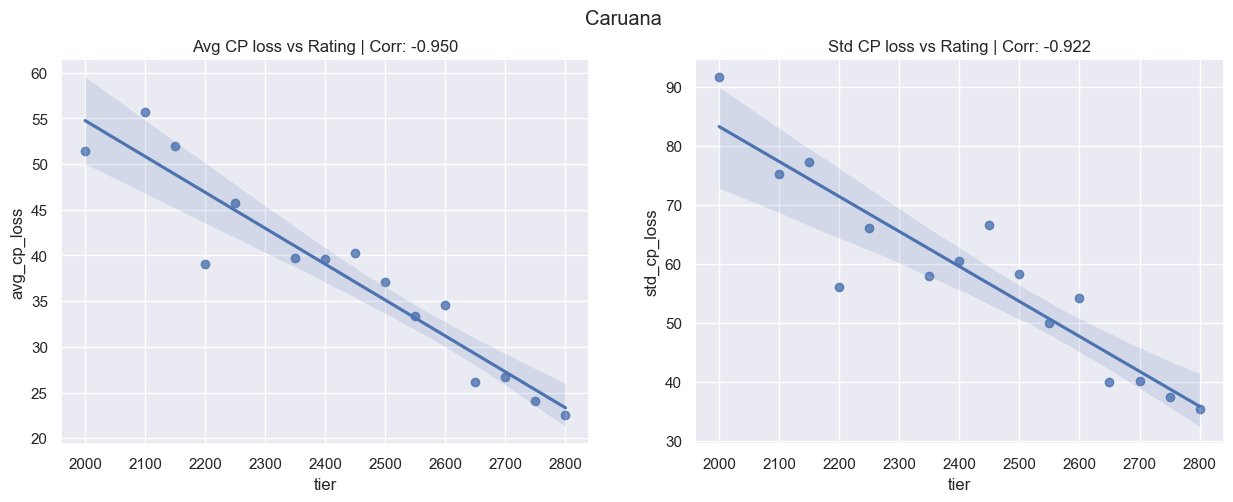

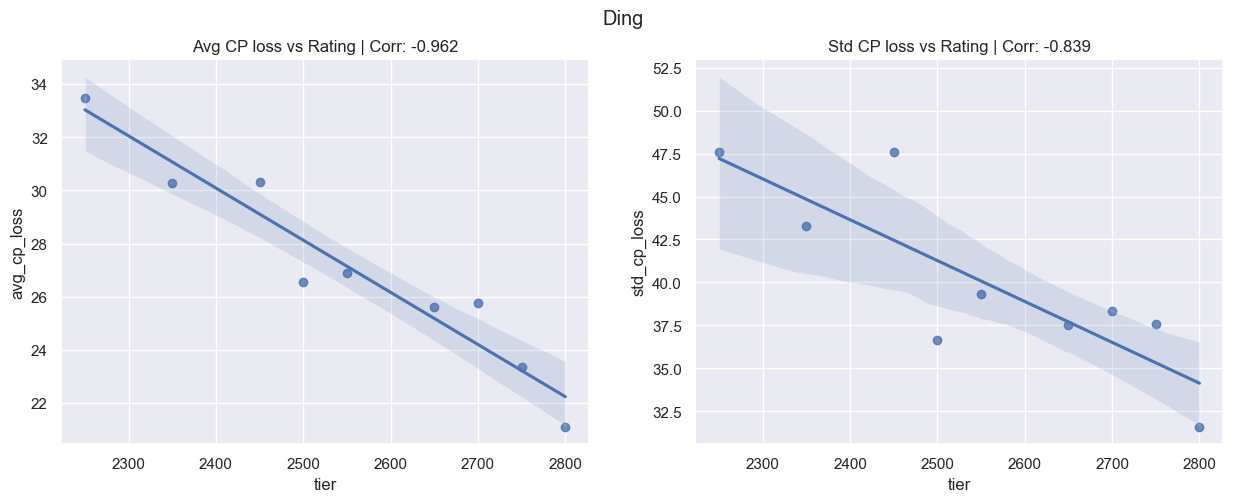

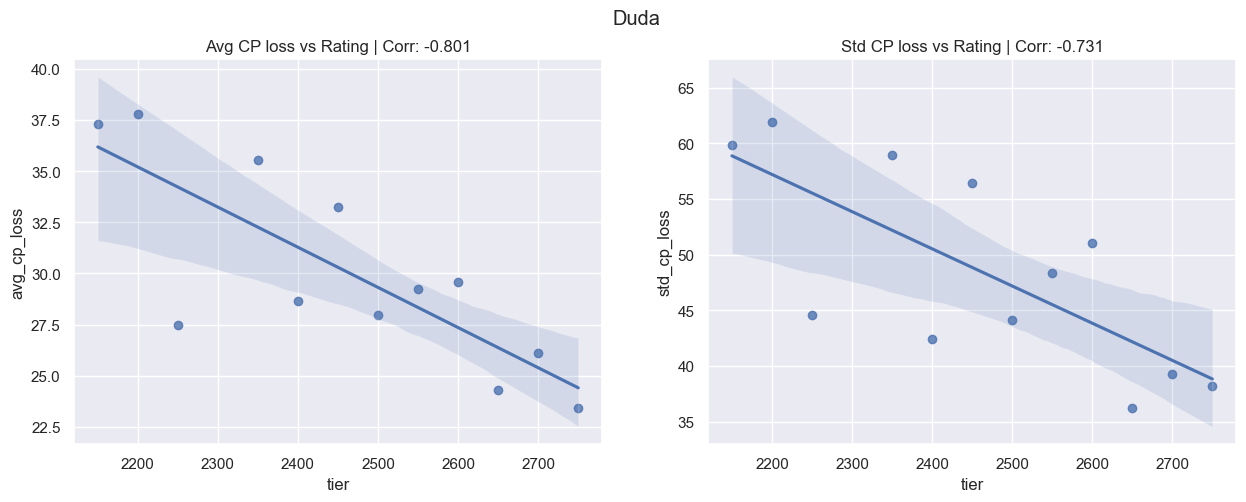

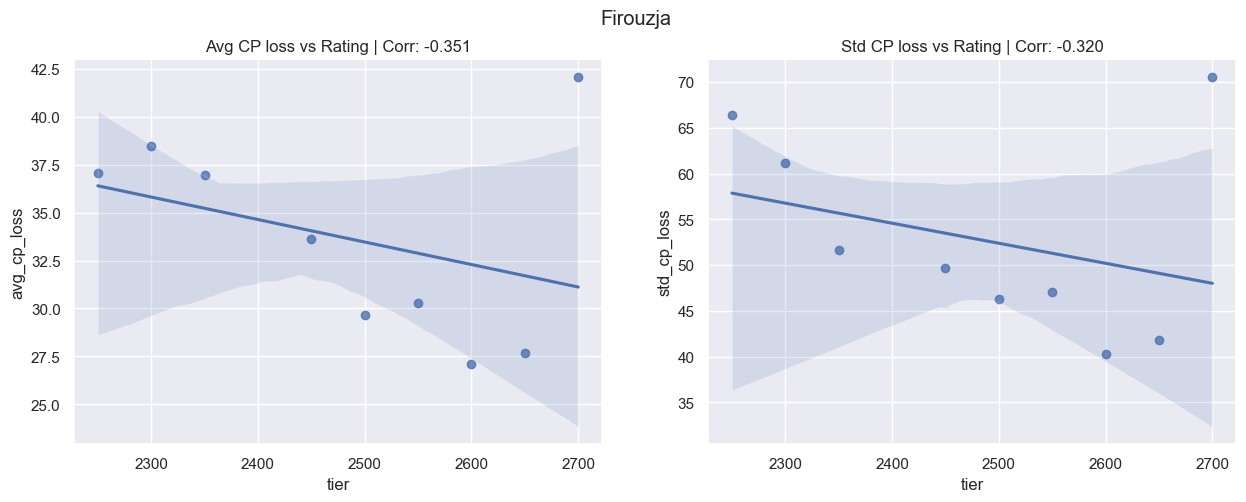

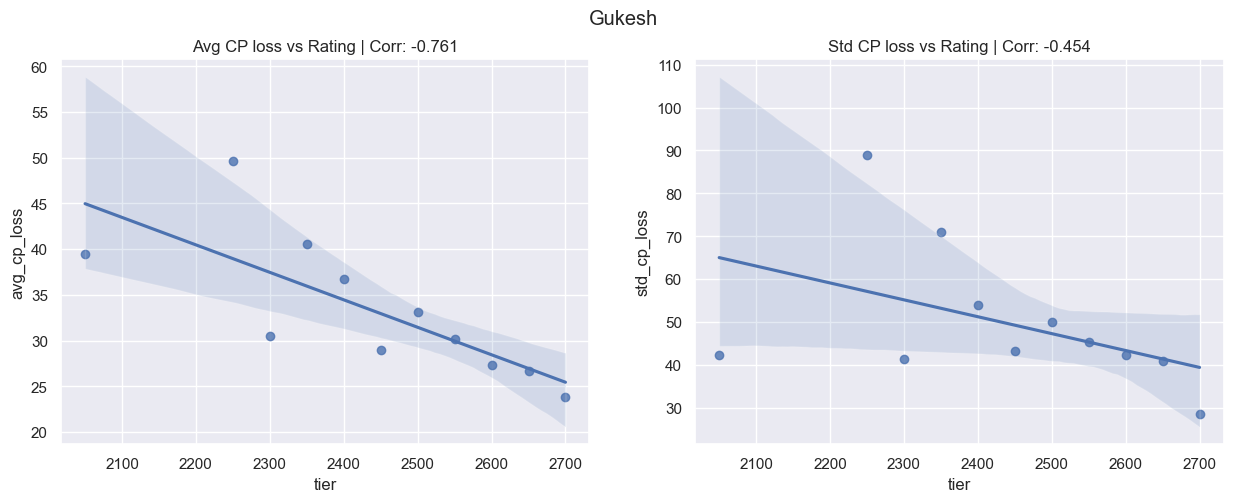

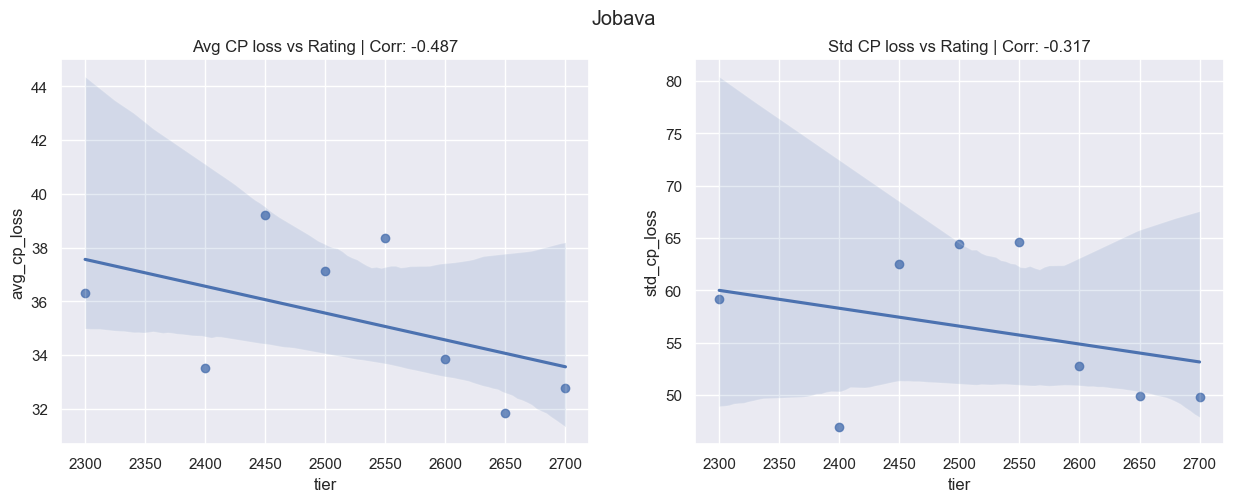

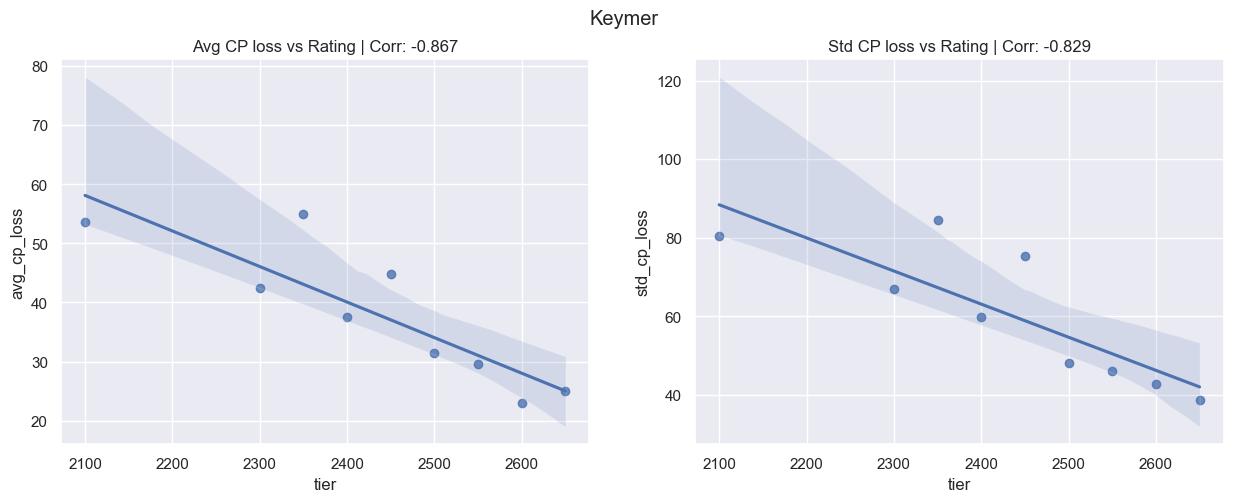

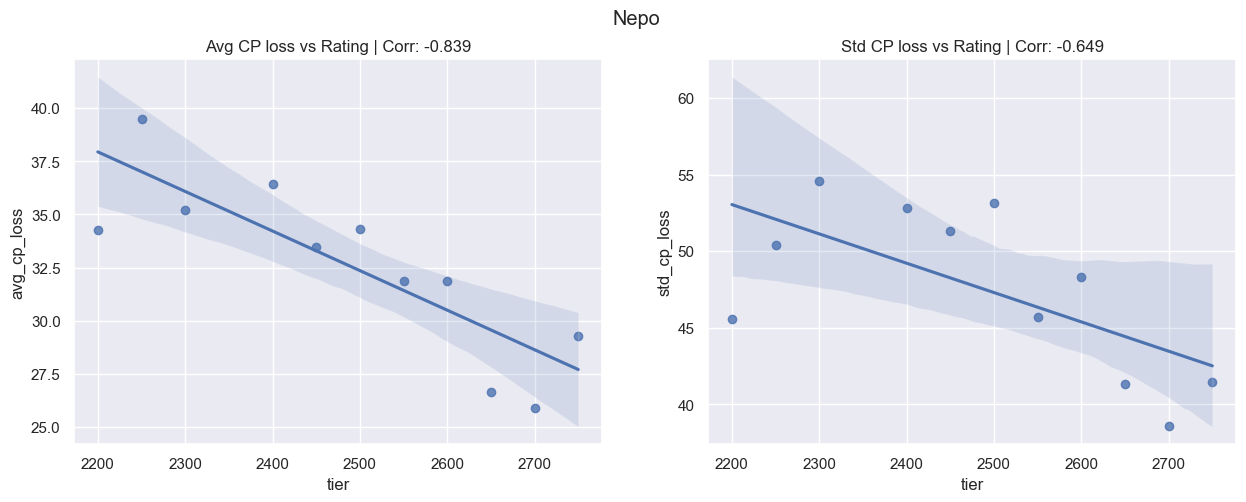

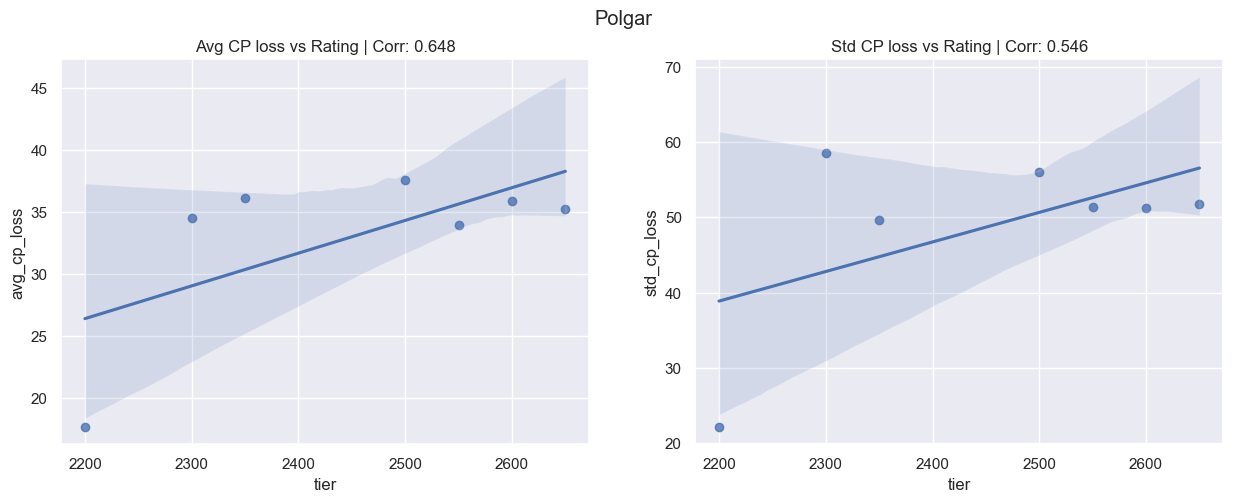

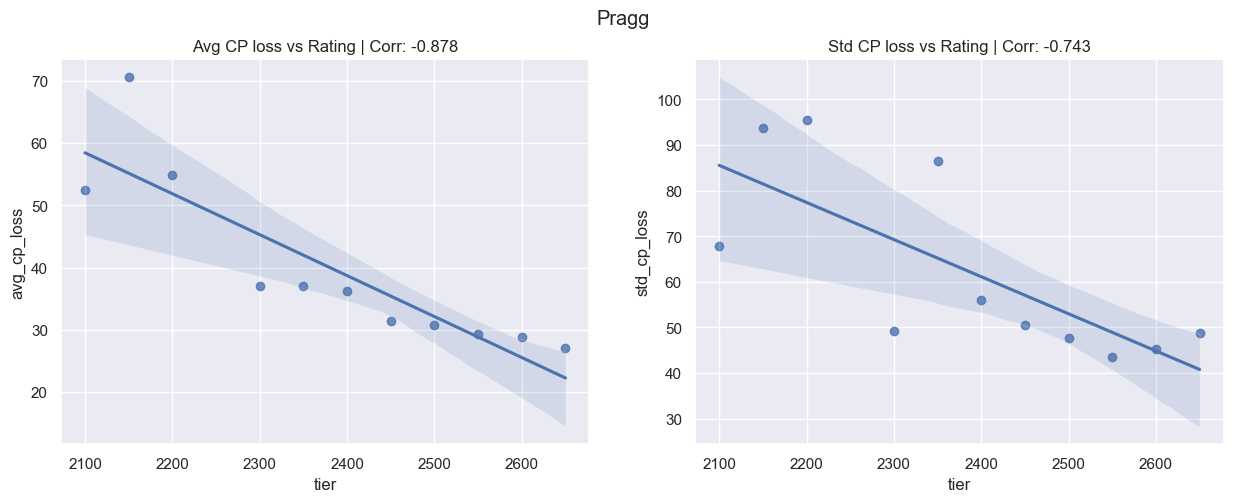

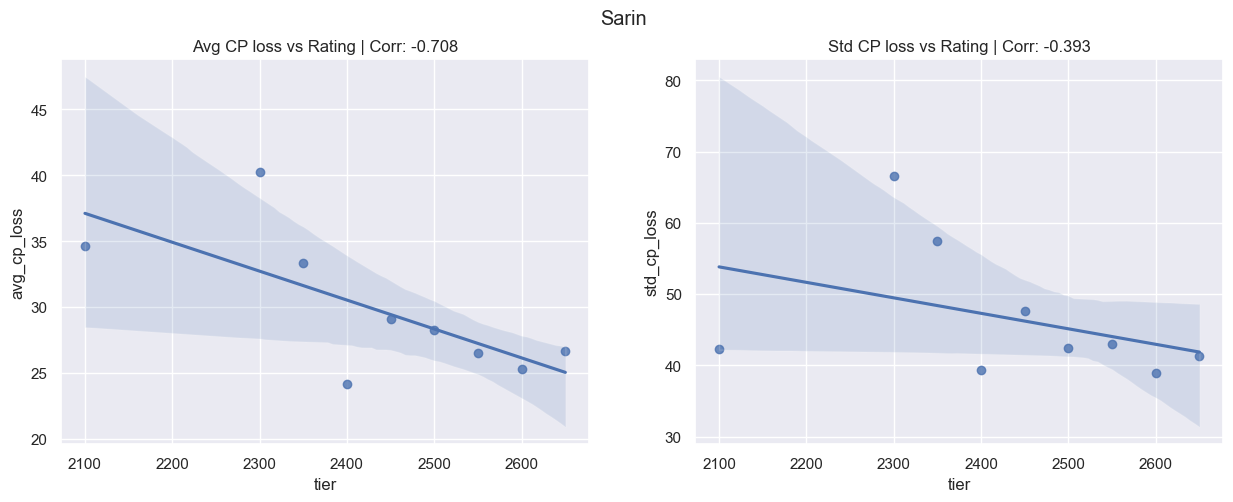

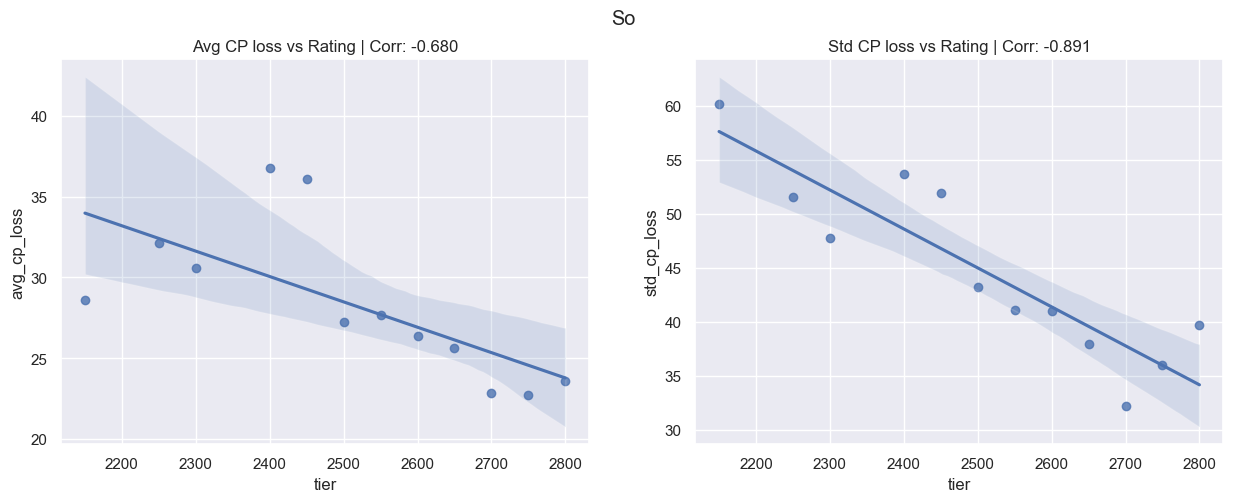

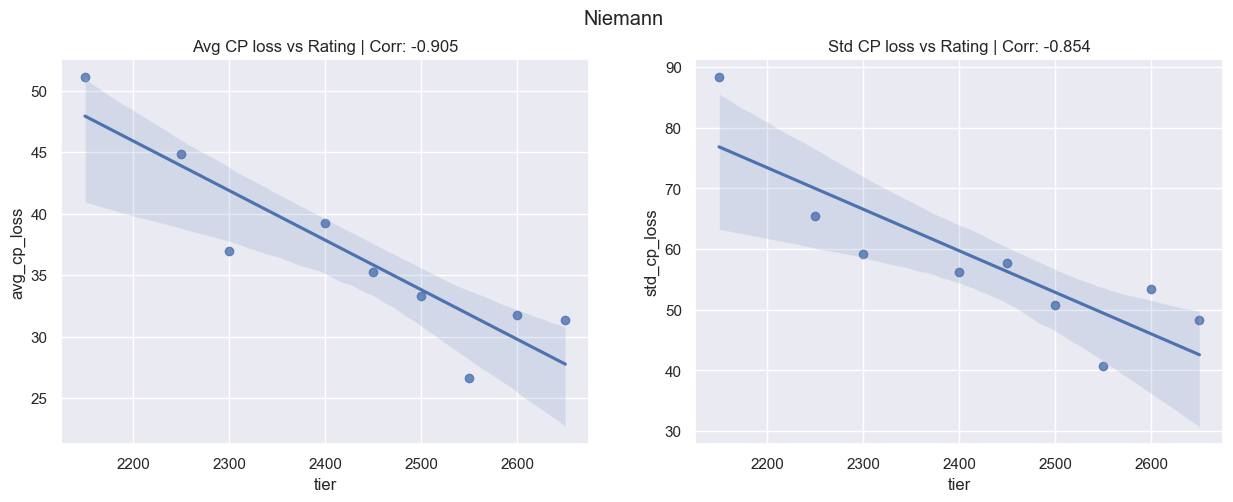

In [20]:
plot_acpl_and_stdcpl_by_tier(df, 'Anand') 
plot_acpl_and_stdcpl_by_tier(df, 'Aronian')
plot_acpl_and_stdcpl_by_tier(df, 'Carlsen')
plot_acpl_and_stdcpl_by_tier(df, 'Caruana')
plot_acpl_and_stdcpl_by_tier(df, 'Ding')
plot_acpl_and_stdcpl_by_tier(df, 'Duda')
plot_acpl_and_stdcpl_by_tier(df, 'Firouzja')
plot_acpl_and_stdcpl_by_tier(df, 'Gukesh')
plot_acpl_and_stdcpl_by_tier(df, 'Jobava')
plot_acpl_and_stdcpl_by_tier(df, 'Keymer')
plot_acpl_and_stdcpl_by_tier(df, 'Nepo')
plot_acpl_and_stdcpl_by_tier(df, 'Polgar')
plot_acpl_and_stdcpl_by_tier(df, 'Pragg')
plot_acpl_and_stdcpl_by_tier(df, 'Sarin')
plot_acpl_and_stdcpl_by_tier(df, 'So')
plot_acpl_and_stdcpl_by_tier(df, 'Niemann')

In [24]:
cp_loss_limits = [30, 20, 15, 10, 5, 3, 1]
num_games_per_player = df['player'].value_counts().to_dict()
sub_cp_limit_loss_df = pd.DataFrame(df['player'].unique(), columns=['player'])
for cp_loss_limit in cp_loss_limits:
    sub_cp_limit_loss_counts = df.groupby('player')['avg_cp_loss'].apply(lambda x: (x<cp_loss_limit).sum()).to_dict()
    sub_cp_limit_loss_df[f'sub_{cp_loss_limit}'] = sub_cp_limit_loss_df.apply(lambda x: 100*sub_cp_limit_loss_counts[x['player']] / num_games_per_player[x['player']], axis=1)

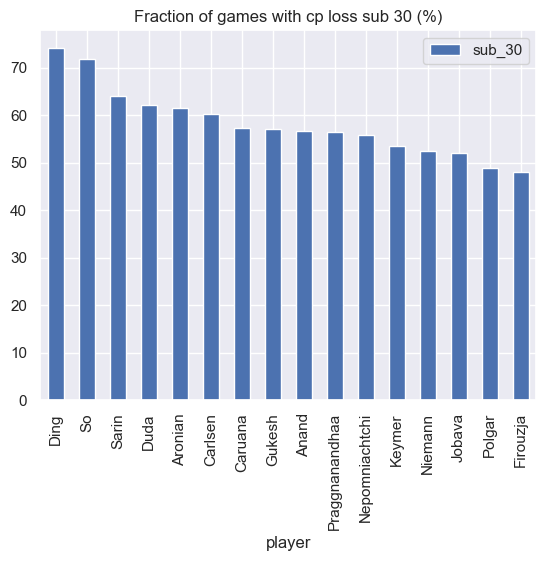

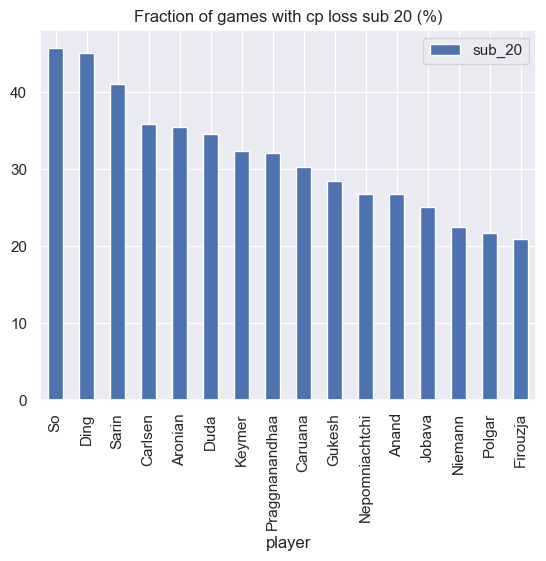

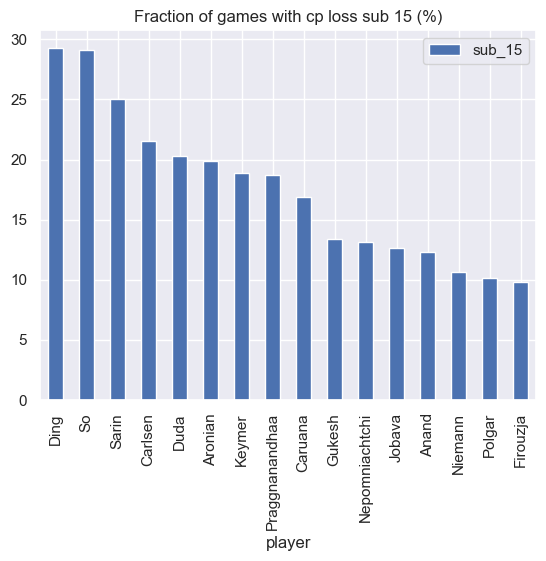

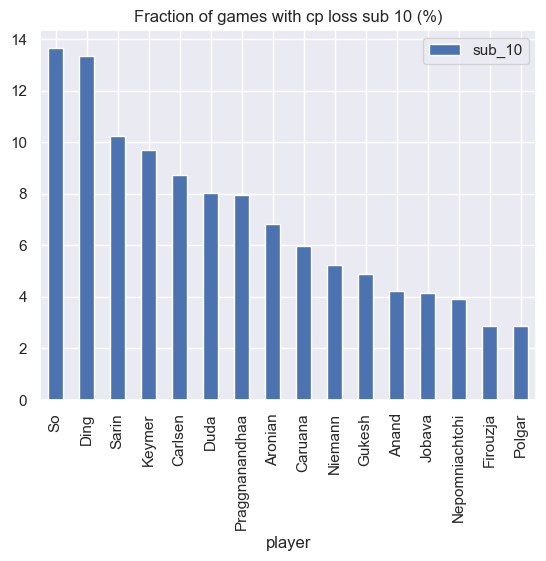

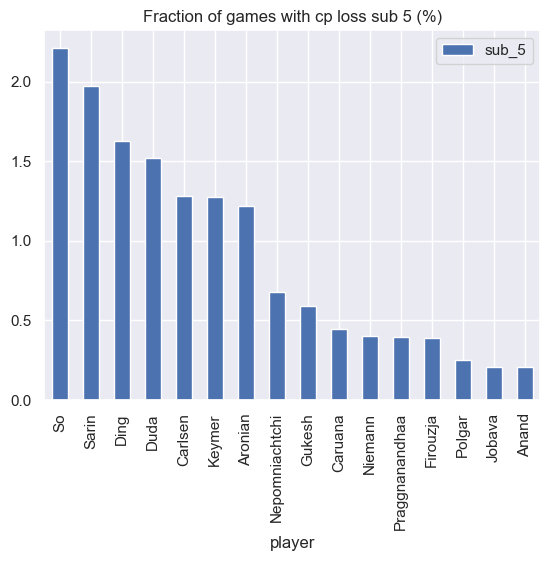

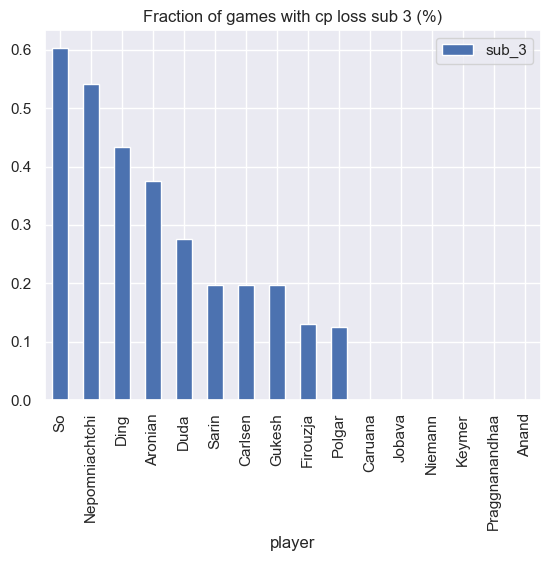

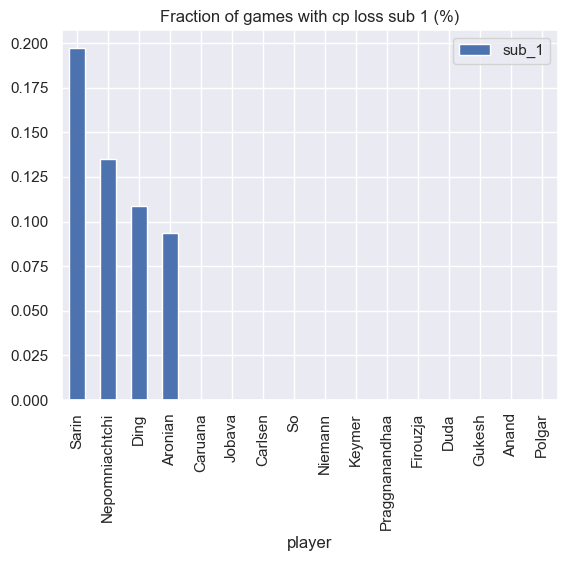

In [25]:
for cp_loss_limit in cp_loss_limits:
    title = f'Fraction of games with cp loss sub {cp_loss_limit} (%)'
    sub_cp_limit_loss_df.sort_values(by=[f'sub_{cp_loss_limit}'], ascending=False).plot.bar(x='player', y=f'sub_{cp_loss_limit}', title=title)

In [19]:
df[df['avg_cp_loss']< 3]

,event,date,player,elo,color,opponent,result,avg_cp_loss,std_cp_loss,tier
3605,26th Fajr Open 2018,2018.02.04,Firouzja,2549.0,white,"Gholami,A",won,2.642857,7.797501,2500
6268,5th MTel Masters,2009.05.21,Carlsen,2770.0,black,"Ivanchuk,V",draw,2.966667,4.813061,2750
6393,35th Cannes Open 2022,2022.02.22,Sarin,2656.0,black,"Girel, Joseph",draw,0.000000,0.000000,2650
8329,Bundesliga 2004-5,2004.11.28,Aronian,2675.0,black,"Ribli,Z",draw,0.000000,0.000000,2650
9265,Tal Memorial,2009.11.08,Aronian,2786.0,black,"Carlsen,M",draw,1.954545,5.304177,2750
9389,44th Olympiad 2022,2022.08.09,Gukesh,2684.0,black,"Keymer, Vincent",draw,2.781250,5.726770,2650
10109,XXI Cracow Open,2010.12.28,Duda,2247.0,white,"Bulski,K",draw,2.666667,5.077182,2200
10981,Lake Sevan 2016,2016.07.20,Duda,2671.0,black,"Ter Sahakyan,S",draw,1.600000,4.029888,2650
11831,4th Young Stars of the World,2006.05.14,Nepomniachtchi,2506.0,black,"Kulikov,Alex RUS",won,2.352941,8.670037,2500
12494,63rd ch-RUS,2010.12.16,Nepomniachtchi,2720.0,white,"Potkin,V",draw,2.750000,6.152574,2700


<AxesSubplot: xlabel='elo', ylabel='avg_cp_loss'>

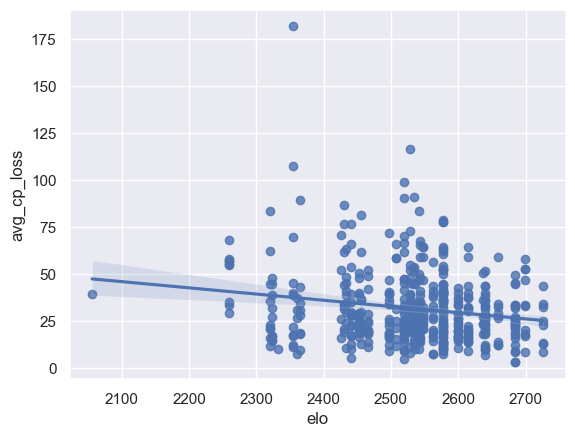

In [28]:
sns.regplot(x='elo', y='avg_cp_loss', data=df[df['player']=='Gukesh']) 

<AxesSubplot: xlabel='elo', ylabel='avg_cp_loss'>

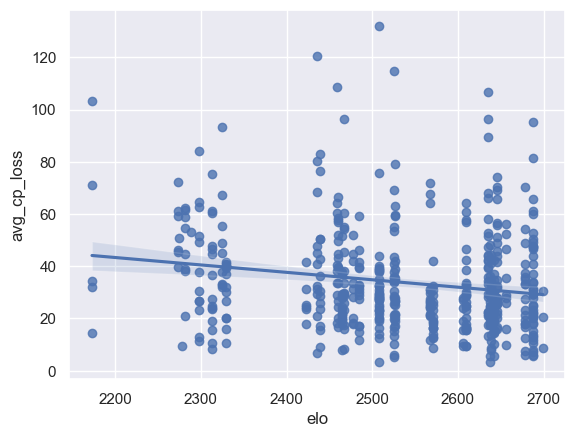

In [29]:
sns.regplot(x='elo', y='avg_cp_loss', data=df[df['player']=='Niemann']) 